#The Use of Deep Neural Networks to Determine the Authenticity of News

######Tomer Atzili, Riya Boyapati, Kyla Perkinson, Srilasya Poruri

## Introduction

Fake news is everywhere, especially in recent years as access to technology spreads and the world becomes further politicized. We wish to use a deep learning algorithm to create a model that evaluates a news article to determine its authenticity. Our decided approach is to use a Long Short-Term Memory (LSTM) network as it is well suited for sequential data, which we have with text articles. In terms of representing the written data numerically, we used a pre-trained BERT model to generate embeddings, which values word importance and context in a text. The combination of these methods, with data and text preprocessing, gave us a trainable model that can pick out key characteristics of a fake news article and use them as predictors for determining authenticity of test articles at 96\% accuracy.

###Required Libraries

In [ ]:
%%capture
! pip install transformers

In [ ]:
import sys
import csv
import math
import re
import time
import torch
import builtins

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from transformers import BertTokenizer, BertModel

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
csv.field_size_limit(sys.maxsize)

131072

##Data Collection

The dataset that we will be using can be found [here](https://www.kaggle.com/c/fake-news/data?select=train.csv). It consists of 20,800 news articles with are either unreliable (1) or reliable (0). Each news article has a unique id, title, author, text, and label. After preprocessing the data and removing articles with no text, the dataset has 20,761 articles, with 10,284 of those being unreliable and 10,387 of them being reliable.

In [ ]:
train_df = pd.read_csv('train.csv', engine='python')
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
# dropping rows with "na" in text since this is the feature we are using
# dropping rows that only contain blank spaces 
train_df = train_df[train_df['text'].notna()]
train_df = train_df[train_df['text'].apply(lambda x: bool(re.search('[a-zA-Z0-9]', x)))]

In [ ]:
print("The training dataset contains", len(train_df['title']), "news articles.")
print("There are", len(train_df[train_df['label']==1]), "unreliable news sources.")
print("There are", len(train_df[train_df['label']==0]), "reliable news sources.")

The training dataset contains 20671 news articles.
There are 10284 unreliable news sources.
There are 10387 reliable news sources.


## Data Processing with BERT

To represent the news articles numerically, we are using a pre-trained BERT (Bidirectional Encoder Representations from Transformers) model to generate embeddings, which values word importance and context in a text. These embeddings will then be used as input for the LSTM network.

In [ ]:
%%capture
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Before creating word embeddings, we are going to tokenize and pad each article. The tokenizer takes the article as input and returns a list of tokens in the article, which is usually a list of individual words. We then add padding if necessary to ensure that each article is the same length.

In [ ]:
inputs_list = []
max_length=512

for article in train_df['text'].tolist():
    tokens = tokenizer.tokenize(article)
    inputs = tokenizer.encode(tokens, return_tensors='pt', max_length = max_length, padding='max_length')
    inputs_list.append(inputs)

BERT is now going to take these tokenized articles as input to create word embeddings for each article. These word embeddings will be saved as individual files.

In [ ]:
outputs_list = []
count = 0
model.cuda()
s = time.time()
with torch.no_grad():
    for i in range(0, len(inputs_list)):
        input = inputs_list[i]
        output = model(input[:, :512].cuda())
        output = output.last_hidden_state
        count = count + 1
        # Save outputs_list in batches
        torch.save(output, f"embeddings/outputs_list_{count}.pth")
        # Free up GPU CUDA memory
        torch.cuda.empty_cache()
        if count % 1000 == 0:
            print(f"Embeddings done: {count}")
            print(time.time() - s)
    print(f"Total embeddings: {count}")

print(time.time() - s)


Embeddings done: 1000
33.196216344833374
Embeddings done: 2000
67.0826210975647
Embeddings done: 3000
102.59281396865845
Embeddings done: 4000
140.23281526565552
Embeddings done: 5000
179.4506721496582
Embeddings done: 6000
217.87053060531616
Embeddings done: 7000
256.81212067604065
Embeddings done: 8000
295.29061102867126
Embeddings done: 9000
334.1515803337097
Embeddings done: 10000
372.7720546722412
Embeddings done: 11000
411.28387570381165
Embeddings done: 12000
449.77943873405457
Embeddings done: 13000
488.37514781951904
Embeddings done: 14000
526.9694283008575
Embeddings done: 15000
565.5922362804413
Embeddings done: 16000
604.3628084659576
Embeddings done: 17000
643.0073375701904
Embeddings done: 18000
681.711678981781
Embeddings done: 19000
720.3640661239624
Embeddings done: 20000
759.0739843845367
Total embeddings: 20671
785.0363698005676


## Defining the Model

We are now defining hyperparameters and splitting our dataset into train, validation, and testing sets. The split is 70/15/15, so 14,500 training embeddings, 3,100 validation embeddings, and 3,070 testing embeddings. Each embedding has the shape [1, 512, 768].

In [ ]:
batch_size = 16
embedding_dim = 768
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 2
learning_rate = .0001
num_epochs = 12
print_every = 10
bidirection = True
train_split_ct = 14500
val_split_ct = 17600
test_split_ct = 20670

train_labels = train_df['label'].tolist()[:train_split_ct]
val_labels = train_df['label'].tolist()[train_split_ct:val_split_ct]
test_labels = train_df['label'].tolist()[val_split_ct:test_split_ct]

To define the LSTM module, we are inputting the word embeddings into PyTorch's LSTM method, then a fully connected layer, and finally a sigmoid layer, where the output is a number between 0 and 1. If the output is less than or equal to 0.5, the article is classified as reliable, else it is classified as unreliable.

In [ ]:
class LSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional):
    super(LSTM, self).__init__()

    self.lstm = nn.LSTM(embedding_dim,
                        hidden_dim,
                        num_layers=n_layers,
                        bidirectional=bidirectional,
                        dropout=.2,
                        batch_first=True)
    
    self.fc = nn.Linear(hidden_dim * 2, output_dim)

    self.sigmoid = nn.Sigmoid()

  def forward(self, input):
    input = torch.squeeze(input)
    output, (hidden, cell) = self.lstm(input)

    hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

    dense_outputs = self.fc(hidden)

    outputs = self.sigmoid(dense_outputs)

    return outputs



In [ ]:
model = LSTM(embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, bidirectional=True)
model.cuda()

LSTM(
  (lstm): LSTM(768, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

###Dataset and Dataloader

In [ ]:
class BERT_dataset(Dataset):
    def __init__(self, dir, mode='train'):
        self.dir = dir
        if mode == 'train':
          self.labelList = torch.tensor(train_labels)
        elif mode == 'val':
          self.labelList = torch.tensor(val_labels)
        else:
          self.labelList = torch.tensor(test_labels)
        self.mode = mode

    def __len__(self):
        if self.mode == 'train':
          return len(train_labels)
        elif self.mode == 'val':
          return len(val_labels)
        else:
          return len(test_labels)
    
    def __getitem__(self, idx):
        if self.mode == 'train':   
          self.data = torch.load(f"{self.dir}{idx+1}.pth")
        elif self.mode == 'val':
          self.data = torch.load(f"{self.dir}{idx+train_split_ct+1}.pth")
        else:
          self.data = torch.load(f"{self.dir}{idx+val_split_ct+1}.pth")
        return self.data,self.labelList[idx]

In [ ]:
trainDataset = BERT_dataset('embeddings/outputs_list_')
trainDataloader = DataLoader(trainDataset,batch_size=batch_size,shuffle=True)

valDataset = BERT_dataset('embeddings/outputs_list_', mode = 'val')
valDataloader = DataLoader(valDataset,batch_size=batch_size,shuffle=True)

testDataset = BERT_dataset('embeddings/outputs_list_', mode = 'test')
testDataloader = DataLoader(testDataset,batch_size=batch_size,shuffle=False)

## Training and Validation

The training loop consists of forward propagation and backwards propagation. The loss is calculated after the forward pass and is then used during backwards propagation to update the weights.

In [ ]:
def trainLoader(model, optimizer, criterion, train_loader):
  epoch_loss = 0
  num_correct = 0.0
  for batch_inputs, batch_labels in train_loader:
    # Reset the gradients
    optimizer.zero_grad()

    # Forward pass
    batch_outputs = model(batch_inputs)

    # Compute the loss
    batch_loss = criterion(torch.squeeze(batch_outputs), batch_labels.float().to("cuda"))

    # Backward pass
    batch_loss.backward()

    # Update the parameters
    optimizer.step()

    # Update the epoch loss
    epoch_loss += batch_loss.item()

    # Compute the number of correct predictions
    batch_predictions = (torch.squeeze(batch_outputs) >= 0.5).long()
    num_correct += (batch_predictions == batch_labels.float().to("cuda")).sum().item()

  return epoch_loss, num_correct

In [ ]:
plot_train_loss = []
def train(model, optimizer, criterion, num_epochs=num_epochs, print_every=print_every):
  for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_correct = 0.0
    length = 0

    model.train()
    length += len(trainDataloader)
    batch_epoch_loss, batch_num_correct = trainLoader(model, optimizer, criterion, trainDataloader)
    epoch_loss += batch_epoch_loss
    num_correct += batch_num_correct


    # Compute the average epoch loss
    avg_epoch_loss = epoch_loss / length

    # Compute training accuracy
    train_acc = num_correct / len(trainDataset)

    plot_train_loss.append(avg_epoch_loss)

    # Print the epoch loss
    if epoch % print_every == 0:
      print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_epoch_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    #Calculate and print Val loss/accuracy
    evaluate(model, criterion, valDataloader)

In [ ]:
plot_val_loss = []
def evaluate(model, criterion, val_loader):
  # Put your model in evaluation mode
  model.eval()

  # Turn off gradient computation for evaluation
  with torch.no_grad():
      val_loss = 0.0
      num_correct = 0

      for batch_inputs, batch_labels in val_loader:
          # Forward pass
          batch_outputs = model(batch_inputs)

          # Compute the loss
          batch_loss = criterion(torch.squeeze(batch_outputs), batch_labels.float().to("cuda"))

          # Update the validation loss
          val_loss += batch_loss.item()

          # Compute the number of correct predictions
          batch_predictions = (torch.squeeze(batch_outputs) >= 0.5).long()
          num_correct += (batch_predictions == batch_labels.float().to("cuda")).sum().item()

      # Compute the average validation loss
      avg_val_loss = val_loss / len(val_loader)
      
      plot_val_loss.append(avg_val_loss)

      # Compute the validation accuracy
      val_acc = num_correct / len(valDataset)

      # Print the validation loss and accuracy
      print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

In [ ]:
train(model, optimizer, criterion, num_epochs=num_epochs, print_every=1)

Epoch 1/12, Training Loss: 0.3537, Training Accuracy: 0.8530
Validation Loss: 0.1939, Validation Accuracy: 0.9339
Epoch 2/12, Training Loss: 0.1721, Training Accuracy: 0.9412
Validation Loss: 0.1540, Validation Accuracy: 0.9413
Epoch 3/12, Training Loss: 0.1332, Training Accuracy: 0.9532
Validation Loss: 0.1391, Validation Accuracy: 0.9497
Epoch 4/12, Training Loss: 0.1059, Training Accuracy: 0.9650
Validation Loss: 0.1315, Validation Accuracy: 0.9545
Epoch 5/12, Training Loss: 0.0906, Training Accuracy: 0.9713
Validation Loss: 0.1314, Validation Accuracy: 0.9565
Epoch 6/12, Training Loss: 0.0770, Training Accuracy: 0.9750
Validation Loss: 0.1228, Validation Accuracy: 0.9594
Epoch 7/12, Training Loss: 0.0631, Training Accuracy: 0.9799
Validation Loss: 0.1221, Validation Accuracy: 0.9626
Epoch 8/12, Training Loss: 0.0550, Training Accuracy: 0.9829
Validation Loss: 0.1614, Validation Accuracy: 0.9458
Epoch 9/12, Training Loss: 0.0434, Training Accuracy: 0.9873
Validation Loss: 0.1460, Va

To see how well the model can generalize to new data, we are going to plot training and validation loss per iteration. Ideally, the training and validation loss should decrease and eventually plateau.

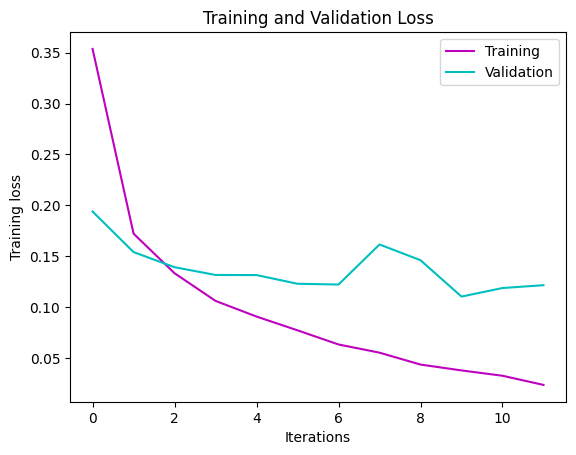

In [ ]:

plt.plot(np.squeeze(plot_train_loss), 'm', label='Training')
plt.plot(np.squeeze(plot_val_loss), 'c', label='Validation')
plt.ylabel('Training loss')
plt.xlabel('Iterations')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Testing

Now we are going to test the model and calculate its accuracy, precision, and recall.

In [ ]:
def test(model, test_loader):
  model.eval()

  with torch.no_grad():
    num_correct = 0
    predictions = []
    correct_labels = []

    for batch_inputs, batch_labels in test_loader:
      batch_outputs = model(batch_inputs)

      batch_predictions = (torch.squeeze(batch_outputs) >= 0.5).long()
      num_correct += (batch_predictions == batch_labels.float().to("cuda")).sum().item()
      predictions.append(batch_predictions.cpu())
      correct_labels.append(batch_labels.cpu())

  test_acc = num_correct / len(testDataset)
  return predictions, correct_labels, test_acc

In [ ]:
predictions, correct_labels, test_acc = test(model, testDataloader)

In [ ]:
predictions = [pred.item() for batch in predictions for pred in batch]
correct_labels = [label.item() for batch in correct_labels for label in batch]

In the context of our project, accuracy is what percent of news articles are accurately classified, precision is the probability that an article the model classifies as unreliable is actually unreliable, and recall is the probability that an unreliable article is detected by the model. 

In [ ]:
print("The testing accuracy is ", test_acc)

The testing accuracy is  0.962214983713355


In [ ]:
print("Precision: ", precision_score(correct_labels, predictions))

Precision:  0.9760479041916168


In [ ]:
print("Recall: ", recall_score(correct_labels, predictions))

Recall:  0.9482870071105365


In [ ]:
print("F1 Score: ", f1_score(correct_labels, predictions))

F1 Score:  0.9619672131147541


Below is the confusion matrix, which provides a visual representation of how many examples are correctly and incorrectly labeled for each class.

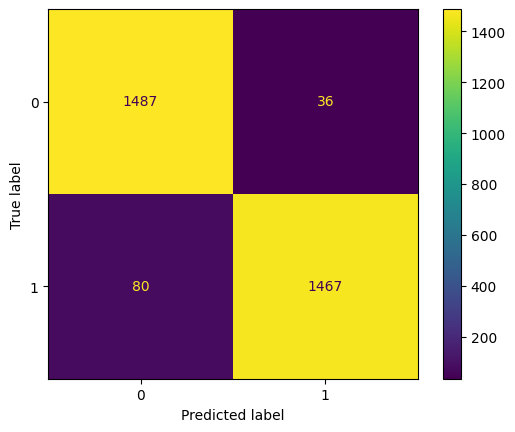

In [ ]:
cm = confusion_matrix(correct_labels, predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

##Future Work

LSTM's introduce the idea of *attention*, but they are not the most cutting-edge models in the deep-learning community. Currently, transformers, using the idea of *self-attention*, are extremely popular for both image and text processing. These models have been producing great results, and it would be interesting to see how a transformer would perform on our BERT embeddings. BERT itself calculates these embeddings with a transformer architecture. Going beyond our architecture, there are some additional tasks that our model could be well suited for. Other binary text classification tasks, such as checking whether a review is positive or negative, would likely work very well with our model given there exists a good dataset to train on. Another extrapolation would be on spoken news. Fake news is not always written, so it would add to our goal to be able to take in audio files as well as text files for testing. This would likely require implementing a third network suited for speech to text tasks and then processing the text as we have.